## Analyze A/B Test Results

A/B testing, also known as split testing, refers to a randomized experimentation process wherein two or more versions of a variable (web page, page element, etc.) are shown to different segments of website visitors at the same time to determine which version leaves the maximum impact and drive business metrics.

## Obejctive of the project

Understand the results of an A/B test run by an e-commerce website. The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

## Table of contents

Part I - Probability

Part II - A/B Test

Part III - Regression

## Part I - Probability

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.shape

(294478, 5)

In [5]:
unique_user = df['user_id'].nunique()
unique_user

290584

In [6]:
df.converted.mean() 

0.11965919355605512

The number of times the new_page and treatment don't line up.

In [7]:
not_line_up_1 = df.query(" group=='treatment' and landing_page=='old_page'").count()

In [8]:
not_line_up_2 = df.query(" group=='control' and landing_page=='new_page'").count()

In [9]:
not_line_up_1 + not_line_up_2

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

In [10]:
#Missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [11]:
# storing the aligned data in df2
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [12]:
# Checking all of the incorrect rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [13]:
df2['converted'].value_counts()

0    255832
1     34753
Name: converted, dtype: int64

In [14]:
df2['user_id'].nunique()

290584

In [15]:
df2['user_id'].duplicated().sum()

1

In [16]:
# to show the duplicated two rows , set "keep = False"
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [17]:
# drop duplicates 
df2.drop_duplicates(keep='first')
df2.duplicated().sum()

0

In [18]:
round(df2.converted.mean(),4)

0.1196

In [19]:
control_ver =float(df2.query("group=='control' and converted=='1'")['user_id'].nunique() ) 
control = float(df2.query("group=='control'")['user_id'].nunique())
round(control_ver / control,4)

0.1204

In [20]:
# Bayes rules 
treat_ver =float(df2.query("group=='treatment' and converted=='1'")['user_id'].nunique() ) 
treat = float(df2.query("group=='treatment'")['user_id'].nunique())
round(treat_ver / treat,4)

0.1188

In [21]:
new_page = float(df2.query("landing_page == 'new_page'")['user_id'].nunique())
total = float(df2.shape[0])
round(new_page / total,4)

0.5001

In [22]:
old_page = float(df2.query("landing_page == 'new_page' and converted == 1 ")['user_id'].nunique())
total = float(df2.query("landing_page == 'new_page'")['user_id'].nunique())
                  
round(old_page / total,4)

0.1188

## Part II - A/B Test¶


Background Information to help you better understand the results :
If P value is really small, less likely to observe the statistic in the null , more likely from the alternative.
p-value is large you will end up staying with the null hypothesis as your choice.

Type 1 error threshold is alpha

If p < alpha , reject the null , choose H1
If p > alpha , fail to reject the null, choose H0
Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time? How long do you run to render a decision that neither page is better than another?

These questions are the difficult parts associated with A/B tests in general.

1. For now, consider you need to make the decision just based on all the data provided. If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be? You can state your hypothesis in terms of words or in terms of $p_{old}$ and $p_{new}$, which are the converted rates for the old and new pages.

Put your answer here.

H_O : p(new)-p(old)<=0 old has better conversion
H_1 : p(new)-p(old)>0 new has better conversion
2. Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the converted success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the converted rate in ab_data.csv regardless of the page.


Use a sample size for each page equal to the ones in ab_data.csv.


Perform the sampling distribution for the difference in converted between the two pages over 10,000 iterations of calculating an estimate from the null.

In [23]:
p_new = round(float(df2.query('converted=="1"').user_id.nunique()) / float(df2.shape[0]), 4)
p_new
# here, pay attention to the variable name , can not be p(new)

0.1196

In [24]:
p_old = round(float(df2.query('converted=="1"').user_id.nunique()) / float(df2.shape[0]) , 4 )
p_old

0.1196

In [25]:
df2.head()


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [26]:
# unique number of accessing new page 
N_new = df2.query('landing_page == "new_page"')['user_id'].nunique()
N_new

145310

In [27]:
# unique number of accessing old page 
N_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
N_old

145274

In [28]:
new_page_converted = np.random.choice([0,1] , N_new , p=(p_new,1-p_new))
new_page_converted

array([1, 1, 1, ..., 1, 1, 1])

In [29]:
old_page_converted = np.random.choice([0,1] , N_old , p=(p_old,1-p_old))
old_page_converted

array([1, 1, 1, ..., 0, 1, 0])

In [30]:
new_page_converted.mean() , old_page_converted.mean()

(0.8801390131443122, 0.8804603714360449)

In [31]:
obs_diff = new_page_converted.mean() - old_page_converted.mean()
obs_diff

-0.0003213582917327429

In [32]:
#import timeit
#start = timeit.default_timer()

# Create sampling distribution for difference in completion rates
# with boostrapping
#p_diffs = []
#size = df.shape[0]
#for _ in range(10000):
#    samp = df2.sample(size, replace = True)
#    new_page_converted = np.random.choice([0,1],N_new, p=(p_new,1-p_new))
#    old_page_converted = np.random.choice([0,1],N_old, p=(p_old,1-p_old))
#    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
    
#Compute python running time.
#stop = timeit.default_timer()
#print(stop - start)

# the above code does not work well and takes too much time to run 


p_diffs=[]
new_convert=np.random.binomial(N_new, p_new, 10000)/N_new
old_convert=np.random.binomial(N_old, p_old, 10000)/N_old
p_diffs=new_convert-old_convert

(array([   6.,   36.,  346., 1444., 3023., 3041., 1605.,  439.,   56.,
           4.]),
 array([-5.15035162e-03, -4.12964497e-03, -3.10893832e-03, -2.08823168e-03,
        -1.06752503e-03, -4.68183802e-05,  9.73888267e-04,  1.99459491e-03,
         3.01530156e-03,  4.03600821e-03,  5.05671486e-03]),
 <a list of 10 Patch objects>)

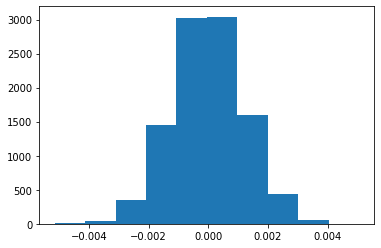

In [33]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)

In [34]:
#compute actual conversion rate
# number of landing new page and converted  / number of landing new page
converted_new = df2.query('converted == 1 and landing_page== "new_page"')['user_id'].nunique()
actual_new = float(converted_new) / float(N_new)

# number of landing old page and converted  / number of landing old page
converted_old = df2.query('converted == 1 and landing_page== "old_page"')['user_id'].nunique()
actual_old = float(converted_old) / float(N_old)

#observed difference in converted rate
obs_diff = actual_diff = actual_new - actual_old
obs_diff

-0.0015782389853555567

In [35]:
# create distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

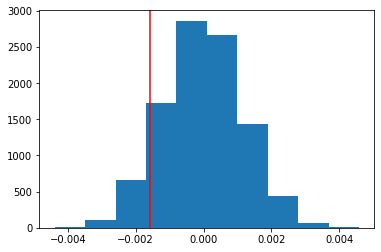

In [36]:
#Plot Null distribution
plt.hist(null_vals)
#Plot vertical line for observed statistic
plt.axvline(x=obs_diff,color ='red')

In [37]:
(null_vals > obs_diff).mean()

0.9054

The value 0.9061 we call it P-value, which suggests if there is a significant difference between 2 groups for a hypothesis. In this case, the new page doesn't have better conversion rates than the old page because the value 0.9 is much higher than the alpha, 0.05(Type I error rate ). We fail to reject the null. Therefore, the data show, with a type I error rate of 0.05, that the old page has higher probablity of convert rate than new page.

l. We could also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let n_old and n_new refer the the number of rows associated with the old page and new pages, respectively.

In [38]:
import statsmodels.api as sm
convert_old = df2.query('converted == 1 and landing_page== "old_page"').user_id.nunique()
convert_new = converted_old = df2.query('converted == 1 and landing_page== "new_page"').user_id.nunique()
n_old = df2.query('landing_page == "old_page"')['user_id'].nunique()
n_new = df2.query('landing_page == "new_page"')['user_id'].nunique()

convert_old,convert_new , n_old , n_new

(17489, 17264, 145274, 145310)

In [39]:
# compute the sm.stats.proportions_ztest using the alternative
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')
z_score, p_value

#  it's a one tail test so a z-score past 1.96 will be significant

(-1.3109241984234394, 0.9050583127590245)

In [40]:
#from scipy.stats import norm
#norm.cdf(z_score) , norm.ppf(1-(0.05/2))
# norm.cdf(z_score):    how significant our z-score is
# norm.ppf(1-(0.05/2))  what our critical value at 95% confidence is

Since the z-score of 1.3109241984234394 does not exceed the critical value of 1.959963984540054, we fail to reject the null hypothesis. Therefore, the converted rate for new page and old page have no difference. This result is the same as parts J. and K. result.

The z-score is greater than the value of -0.1645 (one-tail test) and hence it suggests that we can't reject the null.

And the p-value determines the significance of our resuls. The values are different from parts j and k but it still suggests that there is no statistically significant difference betweem the new and the old page.

## Part III - A regression approach

The goal is to use statsmodels to fit the regression model you specified in part a. to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received. Add an intercept column, as well as an ab_page column, which is 1 when an individual receives the treatment and 0 if control.

In [42]:
# create a colun for the intercept
df2['intercept'] = 1
df2.head()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,timestamp,group,landing_page,converted,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1


In [43]:
# create a dummy variable column for which page each user received
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']
df2.head()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [44]:
log_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [45]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Fri, 02 Apr 2021   Pseudo R-squ.:               8.085e-06
Time:                        14:43:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

p-value associated with ab_page is 0.19, which is different from the value found in PartII (0.9).

Reason :

In Part II, A/B Test method , the hypothesis test is under :
null hypothesis: 𝑝_𝑛𝑒𝑤 <= 𝑝_𝑜𝑙𝑑 , Alternative hypothesis p_new > p_old
In Part III under logistic model, the hypothesis test is under :
null hypothesis: 𝑝_𝑛𝑒𝑤 = 𝑝_𝑜𝑙𝑑 , Alternative hypothesis p_new ≠ p_old
Part III under regression method 'not equal' which is a two sided test, while Part II under A/B test method is a one tailed test

it has something to do with the bimodal distribution. We actually have an effect that the old page has slightly better conversion, the p-value is essentially 2(1 - (value)), to shade the tails. It essentially suggests there is not statistical evidence of a difference in the two conversion rates, but the connection between the p-value here and the p-value above is a bit disconnected because of the directional component of the previous alternative hypothesis.

we can consider "timestamp" becuase the conversion rate is likely to have some kind of connection with different dates when it comes with holiday promotions, or different time like evenings when people get off work.

Disadvantage: the more terms , the model will be more complex. The results will be harder to interprete

In [46]:
df_country = pd.read_csv('countries.csv')
df_country.head()

FileNotFoundError: [Errno 2] File b'countries.csv' does not exist: b'countries.csv'

In [ ]:
df3 = df2.join(df_country.set_index('user_id'),on='user_id')
df3.head()

In [ ]:
df3['country'].value_counts()

In [ ]:
# create dummy variables for country
df3[['US','UK','CA']] = pd.get_dummies(df3['country'])
df3 = df3.drop(df3['CA'])
df3['intercept'] = 1
log_mod = sm.Logit(df3['converted'], df3[['intercept','US','UK','ab_page']]) 
results = log_mod.fit()
results.summary()

In [ ]:
1/np.exp(-0.0150),np.exp(0.0506),np.exp(0.0408)

In [ ]:
# create dummy variables for country
df3['intercept'] = 1
# interaction between page and country 
df3['US_new'] = df3['US'] * df3['ab_page']
df3['UK_new'] = df3['UK'] * df3['ab_page']
log_mod = sm.Logit(df3['converted'], df3[['intercept','ab_page','US','UK','US_new' ,'UK_new' ]])
results = log_mod.fit()
results.summary()